<a href="https://colab.research.google.com/github/larry-deee/CrewAI/blob/main/Tableau_Metadata_extraction_and_analysis_with_CrewAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tableau Metadata extraction and analysis with CrewAI


🌟 Features

* Automated Metadata Extraction: Connects to Tableau Server/Cloud to extract workbook and calculation metadata
* Formula Analysis: Assesses calculated fields against Tableau best practices
* Performance Impact Assessment: Evaluates and rates the performance impact of calculations
* Automated Documentation: Generates comprehensive reports on findings
* Conditional Checks: Ensures analysis completeness and quality
* PDF Reference Integration: Incorporates official Tableau documentation for validated recommendations


**Required Python packages:**
* crewai
* langchain
* requests
* pydantic
* google-colab (if running in Colab environment)

**Other requirements - modify where appropriate**
* 'server': 'https://prod-apsoutheast-a.online.tableau.com',
* PAT_NAME = 'personal_access_token_name'
* PAT_SECRET = 'personal_access_token_secret'
* TABLEAU_SITE = 'site_url'


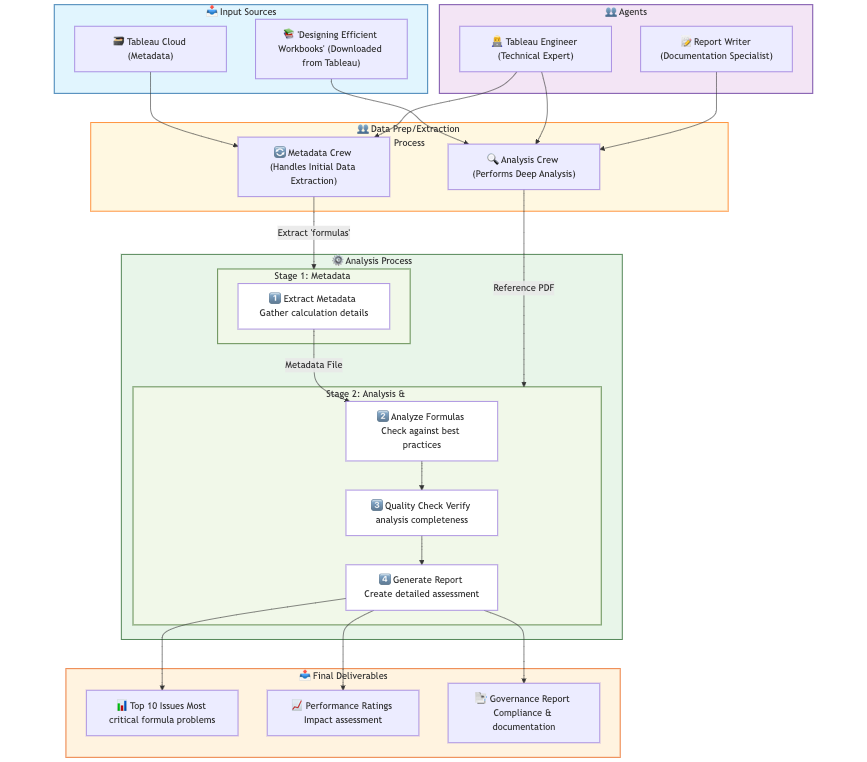

In [ ]:
!pip install langchain-openai
!pip install --upgrade anthropic langchain-anthropic
!pip install grpcio-tools==1.48.2
!pip install opentelemetry-proto==1.26.0
!pip install opentelemetry-exporter-otlp-proto-common==1.26.0
!pip install opentelemetry-exporter-otlp-proto-grpc==1.26.0
!pip install opentelemetry-exporter-otlp-proto-http==1.26.0
!pip install -U duckduckgo-search
!pip install crewai
!pip install 'crewai[tools]'

In [ ]:
from typing import List
from crewai import Agent, Task, Crew, Process, LLM
from pydantic import BaseModel
from crewai.tasks.conditional_task import ConditionalTask
from crewai.tasks.task_output import TaskOutput
from langchain.tools import tool
from crewai_tools import JSONSearchTool, PDFSearchTool
from google.colab import userdata
import os
import json
import requests

# Set up environment variables
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

llm = LLM(model="gpt-4o-mini", temperature=0.5) #max_tokens=4000)

# Files
pdf_url = "https://www.tableau.com/sites/default/files/2021-10/Designing-Efficient-Workbooks-2021-Interworks_0.pdf"
pdf_file_path = "/content/Designing-Efficient-Workbooks-2021-Interworks_0.pdf"
metadata_file_path = "/content/metadata.json"


# Tableau Cloud configuration
TABLEAU_CONFIG = {
    'server': 'https://prod-apsoutheast-a.online.tableau.com',
    'personal_access_token_name': userdata.get('PAT_NAME'),
    'personal_access_token_secret': userdata.get('PAT_SECRET'),
    'site_url': userdata.get('TABLEAU_SITE'),
}



# Define a condition function for the conditional task
def is_data_missing(output: TaskOutput) -> bool:
    try:
        if not hasattr(output, 'pydantic') or not hasattr(output.pydantic, 'events'):
            return True
        return len(output.pydantic.events) < 10
    except Exception:
        return True

def step_callback(step_output):
    print(f"Step completed: {step_output}")

@tool("extract_tableau_metadata")
def extract_tableau_metadata() -> str:
    """Extract metadata from Tableau Server and save it to a file."""
    try:
        # Authentication
        auth_url = f"{TABLEAU_CONFIG['server']}/api/3.22/auth/signin"
        auth_payload = {
            "credentials": {
                "personalAccessTokenName": TABLEAU_CONFIG['personal_access_token_name'],
                "personalAccessTokenSecret": TABLEAU_CONFIG['personal_access_token_secret'],
                "site": {"contentUrl": TABLEAU_CONFIG['site_url']}
            }
        }
        headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

        auth_response = requests.post(auth_url, headers=headers, json=auth_payload)
        token = auth_response.json()['credentials']['token']

        # Metadata extraction
        graphql_url = f"{TABLEAU_CONFIG['server']}/api/metadata/graphql"
        headers['X-Tableau-Auth'] = token

        query = """
        query published_datasources {
          publishedDatasources(filter: {projectNameWithin: ["Data Sources (LD)","Larry"]})  {
            id
            luid
            name
            hasUserReference
            hasExtracts
            extractLastRefreshTime
            site {
              luid
            }
            fields {
              name
              ... on CalculatedField {
                formula
              }
            }
            projectName
            projectVizportalUrlId
            owner {
              luid
            }
            isCertified
            certifier {
              luid
            }
            certificationNote
            certifierDisplayName
            description
          }
        }
        """

        response = requests.post(graphql_url, headers=headers, json={"query": query})
        metadata = response.json()

        # Save to file
        with open('metadata.json', 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=4, ensure_ascii=False)

        return "Metadata successfully extracted and saved to metadata.json"
    except Exception as e:
        return f"Error extracting metadata: {str(e)}"

def initialize_metadata_tool():
    """Initialize JSONSearchTool for metadata analysis."""
    if os.path.exists(metadata_file_path):
        reference_tools['metadata'] = JSONSearchTool(metadata_file_path)
        return True
    return False

class EventOutput(BaseModel):
    events: List[str]

# Initialize tools
reference_tools = {
    'tableau_guide': PDFSearchTool(pdf_file_path),
    'metadata': JSONSearchTool(metadata_file_path)
}

# Create agents
tableau_engineer = Agent(
    role="Tableau Developer and Engineer",
    goal="Extract metadata from Tableau via the metadata API and an expert in Tableau calculations and formulas",
    backstory="Seasoned expert in Tableau development and it's API capability including the REST and "
              "Metadata API's as well as Tableau's calculations (calculated fields) structure and implementation. "
              "Author and Chief Researcher for the Designing Efficient Workbooks knowledgebase/whitepaper.",
    llm=llm,
    tools=[extract_tableau_metadata, reference_tools['metadata'], reference_tools['tableau_guide']],
    verbose=True,
    max_retry_limit=3,
    max_rpm=30
)


tableau_report_writer_agent = Agent(
    role="Tableau Report Writer",
    goal="Generate an assessment report on Tableau calculations with a focus on governance and performance.",
    backstory="An expert report writer specialized in Tableau governance, compliance documentation, and performance analysis.",
    llm=llm,
    cache=True,
    respect_context_window=True,
    verbose=True
)

# Create tasks
extract_task = Task(
    description=f"Check first for the existence of {metadata_file_path}, if not perform an {extract_tableau_metadata} of the metadata from Tableau and save as {metadata_file_path}.",
                #f"The file for reference is {metadata_file_path} and is in JSON format.",
    expected_output=f"Correctly formatted UTF-8 JSON file",
    agent=tableau_engineer,
    #tools=[extract_tableau_metadata],
    verbose=True,
    output_file="extract_task.md",
    async_execution=True,
    llm=llm
)

formula_analysis_task = Task(
    description=f"Retrieves the field tagged as 'formula' from the metadata section using {reference_tools['metadata']} "
                "(e.g. 'formula': ...)' and systematically analyzes them."
                f"Each formula should compare against best practices in the Tableau guide {reference_tools['tableau_guide']}"
                "Specific optimization recommendations where appropriate should be added",
    expected_output=
              "1.The top 10 problematic formulas."
              "2.Suggested improvements/optimisations with citation and reference to the relevant sources and section."
              "3.Impact rating as Low, Medium, or High, with justification specific to performance."
              "4.Detailed and referenced relevant section from the Tableau documentation with regards to performance."
              "5.Structured markdown format without special markdown syntax (like '```')",
    agent=tableau_engineer,
    output_file="formula_analysis.md",
    #context=[extract_task],
    #tool=[reference_tools['metadata']],
    output_pydantic=EventOutput,
    llm=llm
)

# Define a conditional check for the formula count
formula_count_check = ConditionalTask(
    description="Check if the number of formulas matches the expected output count of 10.",
    expected_output="The analysis should produce exactly 10 formulas.",
    condition=is_data_missing,
    verbose=True,
    agent=tableau_engineer,
    output_file="formula_count_check.md"
)


report_writer = Task(
    description="Creation of an assessment report for Tableau calculations"
                "focusing on governance (compliance, documentation, auditability) and performance (efficiency, impact on load time)",
    expected_output=
                "Executive Summary: Objective and scope with citations from reference documentation."
                "Governance Assessment:"
                "Documentation: A list of each calculation's purpose and provide plain-language explanations. Include citations from reference documentation"
                "Compliance: Assigned compliance status and risk rating for each formula/calculation, with rationale."
                "Performance Assessment: Include citations from reference documentation."
                "Efficiency Analysis: A statement on complexity, suggested optimizations (e.g., aggregation)."
                "Impact Rating: Rating on performance impact (Low, Medium, High) with explanations.",

    output_file="report.md",
    agent=tableau_report_writer_agent,
    context=[formula_analysis_task],
    llm=llm,
    human_input=True
)

# Create crews for different stages
metadata_crew = Crew(
    agents=[tableau_engineer],
    tasks=[extract_task],
    process=Process.sequential,
    verbose=True,
    memory=True,
    planning=True
)

analysis_crew = Crew(
    agents=[tableau_engineer, tableau_report_writer_agent],
    tasks=[formula_analysis_task, formula_count_check, report_writer],
    process=Process.sequential,
    verbose=True,
    memory=True,
    planning=True,
    step_callback=step_callback
)


if __name__ == "__main__":
    try:
        print("Starting Tableau Analysis Process...")

        # Download PDF if it does not exist
        if not os.path.exists(pdf_file_path):
            print("Downloading PDF guide...")
            response = requests.get(pdf_url)
            response.raise_for_status()
            with open(pdf_file_path, 'wb') as f:
                f.write(response.content)
            print(f"PDF downloaded successfully to {pdf_file_path}")

        # Extract metadata if needed
        if not os.path.exists(metadata_file_path):
            print("Metadata file not found. Extracting metadata...")
            metadata_result = metadata_crew.kickoff()
            print("Metadata extraction completed:", metadata_result.raw)
            if not initialize_metadata_tool():
                raise Exception("Failed to initialize metadata tool after extraction")
        else:
            if not initialize_metadata_tool():
                raise Exception("Failed to initialize metadata tool from existing file")

        # Run analysis after metadata is available
        print("Starting analysis...")
        analysis_results = analysis_crew.kickoff()
        print("Analysis completed successfully")
        print("Final Results:", analysis_results.raw)  # Use .raw for better output formatting

    except requests.exceptions.RequestException as e:
        print(f"Network Error: {str(e)}")
    except Exception as e:
        print(f"Process Error: {str(e)}")
    finally:
        print("Process completed")